In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2025 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
#
###############################################################################

# ML/AI Best Practices: "Selecting Surrogate Model Form/Size for Optimization"
Maintainer: Brandon Paul  
Author: Brandon Paul  
Updated: 2023-06-01  

In this notebook we demonstrate the use of model and solver statistics to select the best surrogate model. For this purpose we trained (offline) different models with ALAMO, PySMO for three basis forms, and TensorFlow Keras. The surrogates are imported into the notebook, and the IDAES flowsheet is constructed and solved.

## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the ALAMO, PySMO and Keras surrogate trainers, and compares key indicators of model performance. In this notebook, IPOPT will be run with statistics using ALAMO, PySMO Polynomial, PySMO RBF, PySMO Kriging and Keras surrogate models to assess each model type for flowsheet integration and tractability.

## 2. Problem Statement 

Within the context of a larger Natural Gas Fuel Cell (NGFC) system, the autothermal reformer unit is used to generate syngas from air, steam, and natural gas. Two input variables are considered for this example (reformer bypass fraction and fuel to steam ratio). The reformer bypass fraction (also called internal reformation percentage) plays an important role in the syngas final composition and it is typically controlled in this process. The fuel to steam ratio is an important variable that affects the final syngas reaction and heat duty required by the reactor.  The syngas is then used as fuel by a solid-oxide fuel cell (SOFC) to generate electricity and heat. 

The autothermal reformer is typically modeled using the IDAES Gibbs reactor and this reactor is robust once it is initialized; however, the overall model robustness is affected due to several components present in the reaction, scaling issues for the largrangean multipliers, and Gibbs free energy minimization formulation. Substituting rigorously trained and validated surrogates in lieu of rigorous unit model equations increases the robustness of the problem.

### 2.1. Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

### 2.2. Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

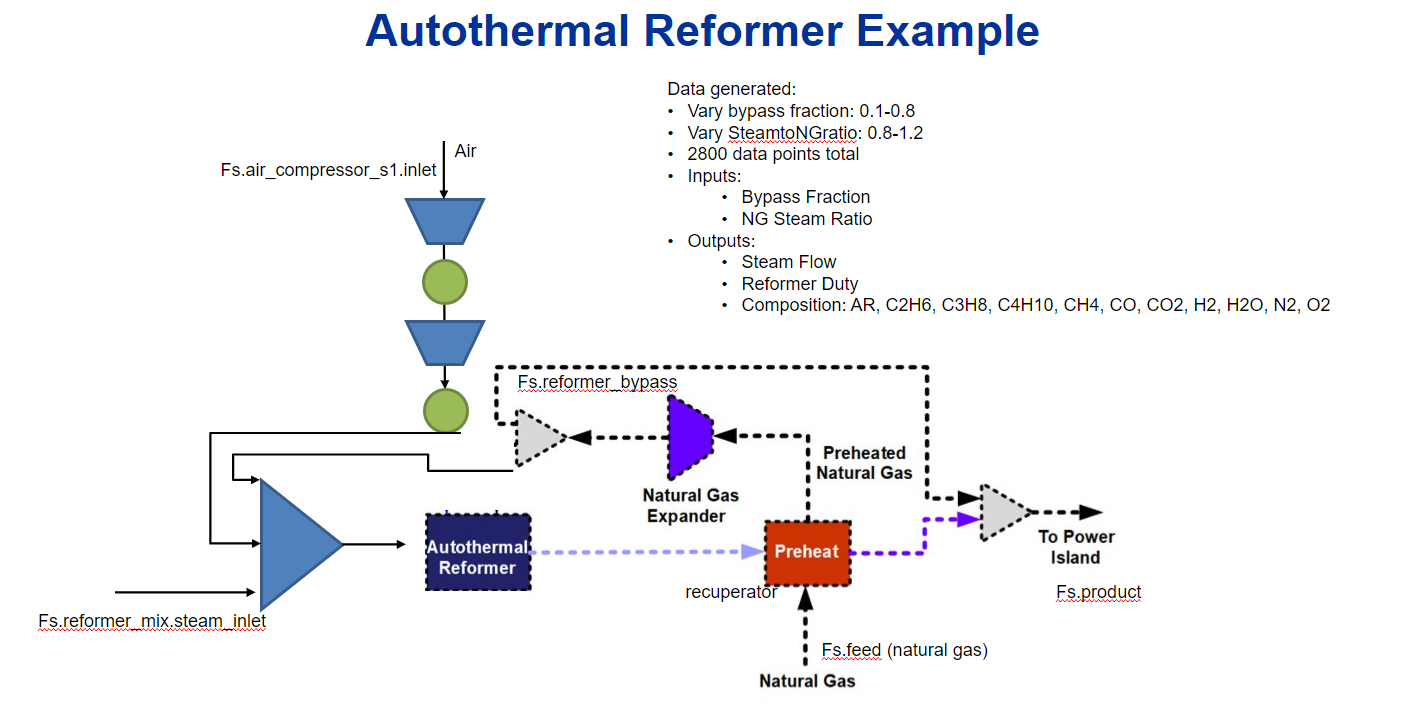

In [2]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path(".") / name


Image(datafile_path("AR_PFD.png"))

## 3. Training Surrogates

Previous Jupyter Notebooks demonstrated the workflow to import data, train surrogate models using [ALAMO](alamo/alamo_flowsheet_optimization_src_doc.md), [PySMO](pysmo/pysmo_flowsheet_optimization_src_doc.md) and Keras, and develop IDAES's validation plots. To keep this notebook simple, this notebook simply loads the surrogate models trained off line.

Note that the training/loading method includes a "retrain" argument in case the user wants to retrain all surrogate models. Since the retrain method runs ALAMO, PySMO (Polynomial, Radial Basis Functions, and Kriging basis types) and Keras, it takes about an 1 hr to complete the training for all models.

Each run will overwrite the serialized JSON files for previously trained surrogates if retraining is enforced. To retrain individual surrogates, simply delete the desired JSON before running this notebook (for Keras, delete the folder `keras_surrogate/`)

In [3]:
from idaes_examples.mod.surrogates.AR_training_methods import (
    train_load_surrogates,
    SurrType,
)

trained_surr = train_load_surrogates(retrain=False)
# setting retrain to True will take ~ 1 hour to run, best to load if possible
# setting retrain to False will only generate missing surrogates (only if JSON/folder doesn't exist)
# this method trains surrogates and serializes to JSON
# The return value is a set of surrogate types (instances of SurrType) that were trained

# imports to capture long output
from io import StringIO
import sys

2025-03-17 17:36:02.752208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 17:36:02.752913: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:36:02.756005: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:36:02.762878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742258162.773996  296077 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742258162.77

Loading existing surrogate models and training missing models.
Any training output will print below; otherwise, models will be loaded without any further output.

Optimizing kriging parameters using L-BFGS-B algorithm...


/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Final results
Theta: [1.133636 0.172046] 
Mean: [[0.712175]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:05 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Steam_Flow trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [2.098572 0.044889] 
Mean: [[24489.420238]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:05 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Reformer_Duty trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...

Final results
Theta: [5.205204 0.045084] 
Mean: [[0.00325]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:05 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output AR trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [5.721231 0.130094] 
Mean: [[0.007353]] 
Regularization parameter: 1e-06

Results saved in  solution.pickle
2025-03-17 17:36:05 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C2H6 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [6.24093  0.001815] 
Mean: [[0.001768]] 
Regularization parameter: 1.0000000001536558e-06

Results saved in  solution.pickle
2025-03-17 17:36:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C3H8 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [2.535505 0.898683] 
Mean: [[0.001241]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C4H10 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [10.72192   0.029391] 
Mean: [[0.19263]] 
Regularization parameter: 1e-06

Results saved in  solution.pickle
2025-03-17 17:36:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CH4 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [4.566243 0.09761 ] 
Mean: [[0.086864]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [3.42649  0.167599] 
Mean: [[0.036997]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO2 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [6.661825 0.01018 ] 
Mean: [[0.239706]] 
Regularization parameter: 1.0000000002854947e-06

Results saved in  solution.pickle
2025-03-17 17:36:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...

Final results
Theta: [0.588033 0.111373] 
Mean: [[0.031395]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2O trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [5.878418 0.019023] 
Mean: [[0.283429]] 
Regularization parameter: 1.000000000001e-06

Results saved in  solution.pickle
2025-03-17 17:36:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output N2 trained successfully



Optimizing kriging parameters using L-BFGS-B algorithm...



Final results
Theta: [0.653803 0.123706] 
Mean: [[0.]] 
Regularization parameter: 1.5856961192994845e-06

Results saved in  solution.pickle
2025-03-17 17:36:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output O2 trained successfully


# 4. Build and Run IDAES Flowsheet

This step builds an IDAES flowsheet and imports the surrogate model objects. As shown in the prior three examples, a single model object accounts for all input and output variables, and the JSON model serialized earlier may be imported into a single SurrogateBlock() component. While the serialization method and file structure differs slightly between the ALAMO, PySMO and Keras Python Wrappers, the three are imported similarly into IDAES flowsheets as shown below.

## 4.1 Build IDAES Flowsheet

This method builds an instance of the IDAES flowsheet model and solves the flowsheet using IPOPT. The method allows users to select a case and the surrogate model type to be used (i.e., alamo, pysmo, keras). The case argument consists of a list with values for the input variables (in this order, bypass split fraction and natural gas to steam ratio). Then the method fixes the input variables values to solve a square problem with IPOPT. 

In [4]:
# Import IDAES and Pyomo libraries
from pyomo.environ import ConcreteModel, SolverFactory, value, Var, Constraint, Set
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core.surrogate.alamopy import AlamoSurrogate
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
from idaes.core.surrogate.keras_surrogate import KerasSurrogate
from idaes.core import FlowsheetBlock


def build_flowsheet(case, surrogate_type: SurrType = None):
    print(case, " ", surrogate_type.value)
    # create the IDAES model and flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    # create flowsheet input variables
    m.fs.bypass_frac = Var(
        initialize=0.80, bounds=[0.1, 0.8], doc="natural gas bypass fraction"
    )
    m.fs.ng_steam_ratio = Var(
        initialize=0.80, bounds=[0.8, 1.2], doc="natural gas to steam ratio"
    )

    # create flowsheet output variables
    m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
    m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
    m.fs.AR = Var(initialize=0, doc="AR fraction")
    m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
    m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
    m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
    m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
    m.fs.CO = Var(initialize=0, doc="CO fraction")
    m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
    m.fs.H2 = Var(initialize=0, doc="H2 fraction")
    m.fs.H2O = Var(initialize=0, doc="H2O fraction")
    m.fs.N2 = Var(initialize=0, doc="N2 fraction")
    m.fs.O2 = Var(initialize=0, doc="O2 fraction")

    # create input and output variable object lists for flowsheet
    inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
    outputs = [
        m.fs.steam_flowrate,
        m.fs.reformer_duty,
        m.fs.AR,
        m.fs.C2H6,
        m.fs.C3H8,
        m.fs.C4H10,
        m.fs.CH4,
        m.fs.CO,
        m.fs.CO2,
        m.fs.H2,
        m.fs.H2O,
        m.fs.N2,
        m.fs.O2,
    ]

    # create the Pyomo/IDAES block that corresponds to the surrogate
    # call correct PySMO object to use below (will let us avoid nested switches)

    # capture long output from loading surrogates (don't need to print it)
    stream = StringIO()
    oldstdout = sys.stdout
    sys.stdout = stream

    if surrogate_type == SurrType.ALAMO:
        surrogate = AlamoSurrogate.load_from_file("alamo_surrogate.json")
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    elif surrogate_type == SurrType.KERAS:
        keras_surrogate = KerasSurrogate.load_from_folder(
            keras_folder_name="keras_surrogate", keras_model_name="keras_model"
        )
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(
            keras_surrogate,
            formulation=KerasSurrogate.Formulation.FULL_SPACE,
            input_vars=inputs,
            output_vars=outputs,
        )
    elif SurrType.is_pysmo(
        surrogate_type
    ):  # surrogate is one of the three pysmo basis options
        surrogate = PysmoSurrogate.load_from_file(
            surrogate_type.value + "_surrogate.json"
        )
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    else:
        raise ValueError(f"Unknown surrogate type: {surrogate_type}")

    # revert to standard output
    sys.stdout = oldstdout

    # fix input values and solve flowsheet
    m.fs.bypass_frac.fix(case[0])
    m.fs.ng_steam_ratio.fix(case[1])

    solver = SolverFactory("ipopt")
    try:  # attempt to solve problem
        results = solver.solve(m, tee=True)
    except:  # retry solving one more time
        results = solver.solve(m, tee=True)

    return (
        value(m.fs.steam_flowrate),
        value(m.fs.reformer_duty),
        value(m.fs.C2H6),
        value(m.fs.CH4),
        value(m.fs.H2),
        value(m.fs.O2),
    )

## 4.2 Model Size/Form Comparison

As mentioned above, as part of best practices the IDAES ML/AI demonstration includes the analysis of model/solver statistics and performance to determine the best surrogate model, including model size, model form, model trainer, etc. This section provides the rigorous analysis of solver performance comparing different surrogate models (ALAMO, PySMO polynomial, PysMO RBF, and PySMO Kriging).

To obtain the results, we run the flowsheet for ten different simulation cases for each surrogate model type. Since the simulation cases are obtained from the training data set we can compare model performance (absolute error of measurement vs predicted output values).

In [5]:
# Import Auto-reformer training data
import numpy as np
import pandas as pd

np.set_printoptions(precision=6, suppress=True)
csv_data = pd.read_csv(r"reformer-data.csv")  # 2800 data points

# extracting 10 data points out of 2800 data points, randomly selecting 10 cases to run
case_data = csv_data.sample(n=10)

# selecting columns that correspond to Input Variables
inputs = np.array(case_data.iloc[:, :2])

# selecting columns that correspond to Output Variables
cols = ["Steam_Flow", "Reformer_Duty", "C2H6", "CH4", "H2", "O2"]
outputs = np.array(case_data[cols])

# For results comparison with minimum memory usage we will extract the values to plot on each pass
# note that the entire model could be returned and saved on each loop if desired

# create empty dictionaries so we may easily index results as we save them
# for convenience while plotting, each output variable has its own dictionary
# indexed by (case number, trainer type)
# trainers = ["alamo", "pysmo_poly", "pysmo_rbf", "pysmo_krig", "keras"]
# temporarily remove keras
trainers = list(trained_surr - {SurrType.KERAS})

cases = range(len(inputs))
steam_flow_error = {}
reformer_duty_error = {}
conc_C2H6 = {}
conc_CH4 = {}
conc_H2 = {}
conc_O2 = {}

# run flowsheet for each trainer and save results
i = 0
for case in inputs:  # each case is a value pair (bypass_frac, ng_steam_ratio)
    i = i + 1
    for trainer in trainers:
        [
            sf,
            rd,
            eth,
            meth,
            hyd,
            oxy,
        ] = build_flowsheet(case, surrogate_type=trainer)
        steam_flow_error[(i, trainer)] = abs(
            (sf - value(outputs[i - 1, 0])) / value(outputs[i - 1, 0])
        )
        reformer_duty_error[(i, trainer)] = abs(
            (rd - value(outputs[i - 1, 1])) / value(outputs[i - 1, 1])
        )
        conc_C2H6[(i, trainer)] = abs(eth - value(outputs[i - 1, 2]))
        conc_CH4[(i, trainer)] = abs(meth - value(outputs[i - 1, 3]))
        conc_H2[(i, trainer)] = abs(hyd - value(outputs[i - 1, 4]))
        conc_O2[(i, trainer)] = abs(oxy - value(outputs[i - 1, 5]))

[0.221739 1.021053]   pysmo_kriging


2025-03-17 17:36:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.221739 1.021053]   pysmo_poly
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.221739 1.021053]   pysmo_rbf
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.302899 1.168421]   pysmo_kriging
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.302899 1.168421]   pysmo_poly
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.302899 1.168421]   pysmo_rbf
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.546377 0.884211]   pysmo_kriging
2025-03-17 17:36:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.546377 0.884211]   pysmo_poly
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.546377 0.884211]   pysmo_rbf
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.678261 1.084211]   pysmo_kriging
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.678261 1.084211]   pysmo_poly
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.678261 1.084211]   pysmo_rbf
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.657971 1.063158]   pysmo_kriging
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.657971 1.063158]   pysmo_poly
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.657971 1.063158]   pysmo_rbf
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.12029  0.863158]   pysmo_kriging
2025-03-17 17:36:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.12029  0.863158]   pysmo_poly
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.12029  0.863158]   pysmo_rbf
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.333333 1.      ]   pysmo_kriging
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.333333 1.      ]   pysmo_poly
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.333333 1.      ]   pysmo_rbf
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.373913 0.926316]   pysmo_kriging
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.373913 0.926316]   pysmo_poly
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.373913 0.926316]   pysmo_rbf
2025-03-17 17:36:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.515942 1.2     ]   pysmo_kriging
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.515942 1.2     ]   pysmo_poly
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.515942 1.2     ]   pysmo_rbf
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.688406 1.147368]   pysmo_kriging
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.688406 1.147368]   pysmo_poly
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[0.688406 1.147368]   pysmo_rbf
2025-03-17 17:36:12 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

We can visualize these results by plotting a graph for each of the quantities above, creating a data series for each surrogate trainer. Some data series may overlay if values are identical for all cases:

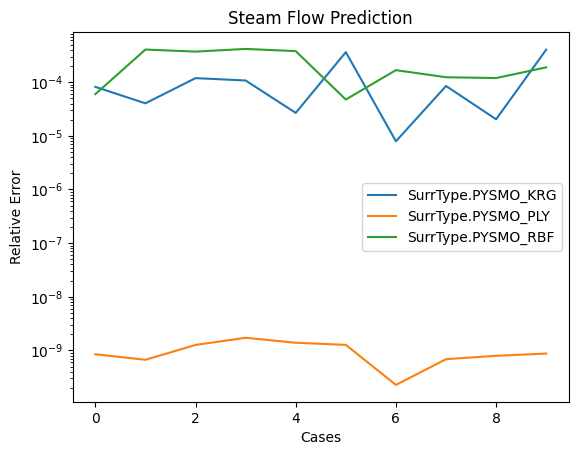

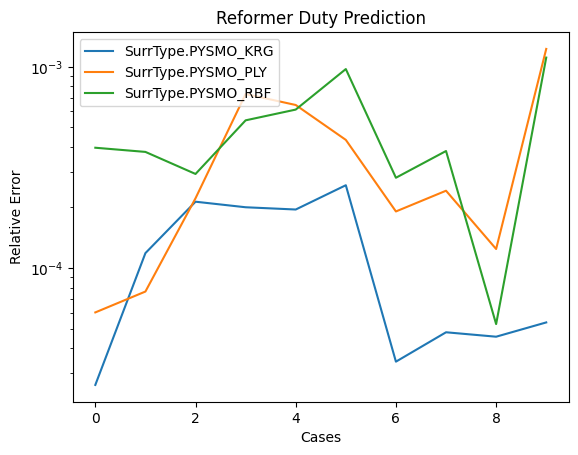

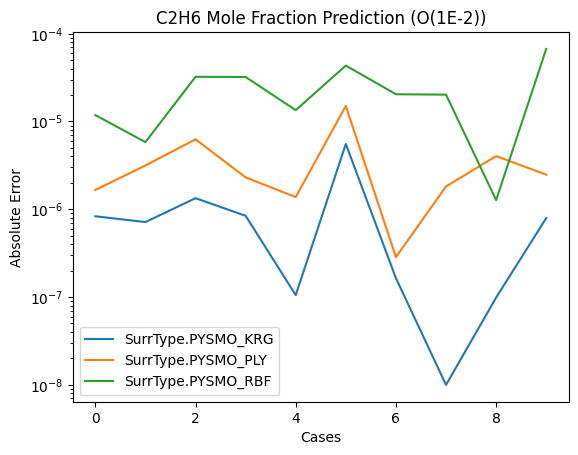


Mole fraction predictions displayed with absolute error:



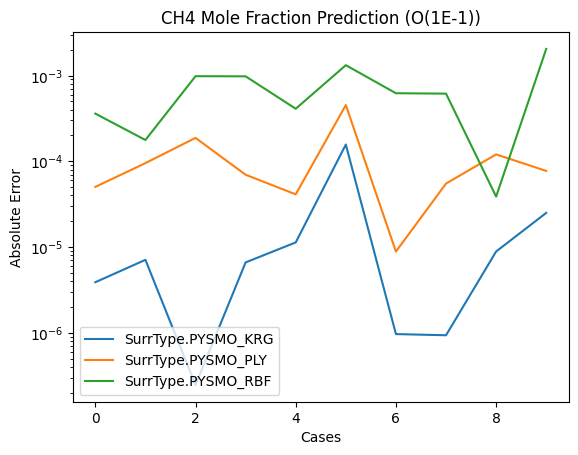

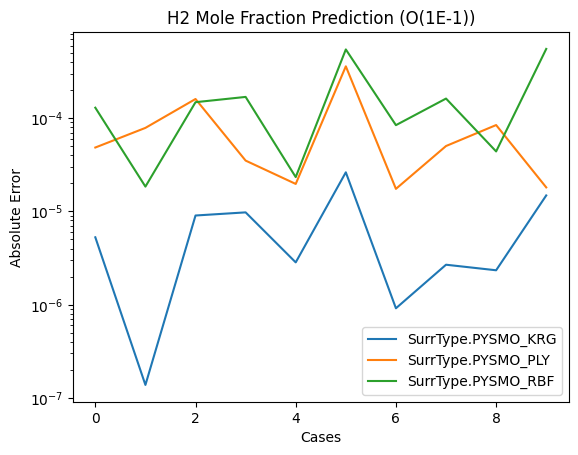

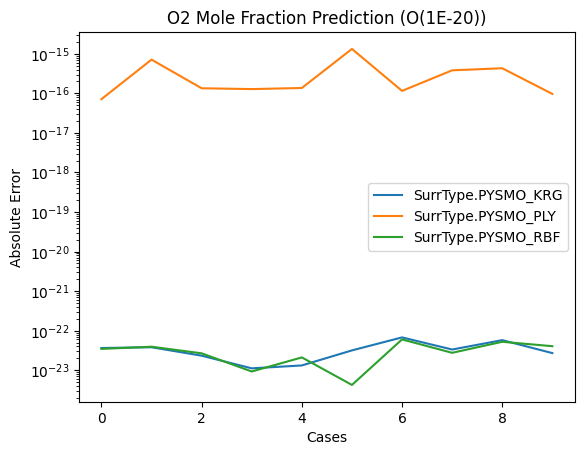

In [6]:
from matplotlib import pyplot as plt

# create figure/axes for each plot sequentially, plotting each trainer as a separate data series

# Steam Flow Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    sf = [steam_flow_error[(i, j)] for (i, j) in steam_flow_error if j == trainer]
    ax.plot(cases, sf, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Relative Error")
ax.set_title("Steam Flow Prediction")
ax.legend()
plt.yscale("log")
plt.show()

# Reformer Duty Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    rd = [reformer_duty_error[(i, j)] for (i, j) in reformer_duty_error if j == trainer]
    ax.plot(cases, rd, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Relative Error")
ax.set_title("Reformer Duty Prediction")
ax.legend()
plt.yscale("log")
plt.show()

# C2H6 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    eth = [conc_C2H6[(i, j)] for (i, j) in conc_C2H6 if j == trainer]
    ax.plot(cases, eth, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Absolute Error")
ax.set_title("C2H6 Mole Fraction Prediction (O(1E-2))")
ax.legend()
plt.yscale("log")
plt.show()

print()
print("Mole fraction predictions displayed with absolute error:")
print()

# CH4 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    meth = [conc_CH4[(i, j)] for (i, j) in conc_CH4 if j == trainer]
    ax.plot(cases, meth, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Absolute Error")
ax.set_title("CH4 Mole Fraction Prediction (O(1E-1))")
ax.legend()
plt.yscale("log")
plt.show()

# H2 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    hyd = [conc_H2[(i, j)] for (i, j) in conc_H2 if j == trainer]
    ax.plot(cases, hyd, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Absolute Error")
ax.set_title("H2 Mole Fraction Prediction (O(1E-1))")
ax.legend()
plt.yscale("log")
plt.show()

# O2 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    oxy = [conc_O2[(i, j)] for (i, j) in conc_O2 if j == trainer]
    ax.plot(cases, oxy, label=trainer)
# add info to plot
ax.set_xlabel("Cases")
ax.set_ylabel("Absolute Error")
ax.set_title("O2 Mole Fraction Prediction (O(1E-20))")
ax.legend()
plt.yscale("log")
plt.show()

## 4.3 Comparing Surrogate Optimization
Extending this analysis, we will run a single optimization scenario for each surrogate model and compare results. As in previous examples detailing workflows for [ALAMO](alamo_flowsheet_optimization_src_doc.md), [PySMO](pysmo_flowsheet_optimization_src_doc.md) and [Keras](keras_flowsheet_optimization_src_doc.md), we will optimize hydrogen production while restricting nitrogen below 34 mol% in the product stream.

In [7]:
# Import additional Pyomo libraries
from pyomo.environ import Objective, maximize


def run_optimization(surrogate_type=None):
    print(surrogate_type)
    # create the IDAES model and flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    # create flowsheet input variables
    m.fs.bypass_frac = Var(
        initialize=0.80, bounds=[0.1, 0.8], doc="natural gas bypass fraction"
    )
    m.fs.ng_steam_ratio = Var(
        initialize=0.80, bounds=[0.8, 1.2], doc="natural gas to steam ratio"
    )

    # create flowsheet output variables
    m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
    m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
    m.fs.AR = Var(initialize=0, doc="AR fraction")
    m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
    m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
    m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
    m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
    m.fs.CO = Var(initialize=0, doc="CO fraction")
    m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
    m.fs.H2 = Var(initialize=0, doc="H2 fraction")
    m.fs.H2O = Var(initialize=0, doc="H2O fraction")
    m.fs.N2 = Var(initialize=0, doc="N2 fraction")
    m.fs.O2 = Var(initialize=0, doc="O2 fraction")

    # create input and output variable object lists for flowsheet
    inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
    outputs = [
        m.fs.steam_flowrate,
        m.fs.reformer_duty,
        m.fs.AR,
        m.fs.C2H6,
        m.fs.C3H8,
        m.fs.C4H10,
        m.fs.CH4,
        m.fs.CO,
        m.fs.CO2,
        m.fs.H2,
        m.fs.H2O,
        m.fs.N2,
        m.fs.O2,
    ]

    # create the Pyomo/IDAES block that corresponds to the surrogate
    # call correct PySMO object to use below (will let us avoid nested switches)

    # capture long output from loading surrogates (don't need to print it)
    stream = StringIO()
    oldstdout = sys.stdout
    sys.stdout = stream

    if surrogate_type == SurrType.ALAMO:
        surrogate = AlamoSurrogate.load_from_file("alamo_surrogate.json")
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    elif surrogate_type == SurrType.KERAS:
        keras_surrogate = KerasSurrogate.load_from_folder(
            keras_folder_name="keras_surrogate", keras_model_name="keras_model"
        )
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(
            keras_surrogate,
            formulation=KerasSurrogate.Formulation.FULL_SPACE,
            input_vars=inputs,
            output_vars=outputs,
        )
    elif SurrType.is_pysmo(
        surrogate_type
    ):  # surrogate is one of the three pysmo basis options
        surrogate = PysmoSurrogate.load_from_file(
            surrogate_type.value + "_surrogate.json"
        )
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    else:
        raise ValueError(f"Unknown surrogate type: {surrogate_type}")

    # revert to standard output
    sys.stdout = oldstdout

    # unfix input values and add the objective/constraint to the model
    m.fs.bypass_frac.unfix()
    m.fs.ng_steam_ratio.unfix()
    m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
    m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

    solver = SolverFactory("ipopt")
    try:  # attempt to solve problem
        results = solver.solve(m, tee=True)
    except:  # retry solving one more time
        results = solver.solve(m, tee=True)

    return inputs, outputs

In [8]:
# create list objects to store data, run optimization
results = {}
for trainer in trainers:
    inputs, outputs = run_optimization(trainer)
    for var in inputs:
        results[(var.name, trainer)] = value(var)
    for var in outputs:
        results[(var.name, trainer)] = value(var)

SurrType.PYSMO_KRG
2025-03-17 17:36:14 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

SurrType.PYSMO_PLY
2025-03-17 17:36:14 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

SurrType.PYSMO_RBF
2025-03-17 17:36:14 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [9]:
# print results as a table
df_index = []
for var in inputs:
    df_index.append(var.name)
for var in outputs:
    df_index.append(var.name)
df_cols = trainers

df = pd.DataFrame(index=df_index, columns=df_cols)
for i in df_index:
    for j in df_cols:
        df[j][i] = results[(i, j)]

df  # display results table

/tmp/ipykernel_296077/4045444663.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[j][i] = results[(i, j)]


,SurrType.PYSMO_KRG,SurrType.PYSMO_PLY,SurrType.PYSMO_RBF
fs.bypass_frac,0.1,0.1,0.1
fs.ng_steam_ratio,1.124523,1.126451,1.124305
fs.steam_flowrate,1.22647,1.228592,1.226153
fs.reformer_duty,39080.249728,39131.26643,39062.177089
fs.AR,0.004107,0.004107,0.004107
fs.C2H6,0.000518,0.000519,0.000545
fs.C3H8,0.000114,0.000114,0.000119
fs.C4H10,0.000065,0.000065,0.000068
fs.CH4,0.016193,0.0162,0.016991
fs.CO,0.104839,0.104419,0.104856
